In [3]:
import numpy as np
import os
import sys
from util.utils import load_sitk,save_sitk,Dice
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.measurements import label as CClabel

In [5]:
data_dir = '/proj/NIRAL/users/siyangj/NewModels/model_0405_report/models/1/real_ensemble/'

true_path = '/proj/NIRAL/users/siyangj/myData/min_normal/seg_inf_1/1.nrrd'

true_im = load_sitk(true_path)

im_size = (96,112,96)
output_image = np.zeros(im_size + (4,))
for b in ['660','best','700']:
    _path = os.path.join(data_dir,'batch_'+b,'prediction-1.nrrd')
    _im = load_sitk(_path)
    print Dice(_im,true_im)
    for _l in xrange(4):
        output_image[:,:,:,_l] += (_im==_l).astype(int)
output_image = np.argmax(output_image,axis=-1)

[0.99460224 0.84364008 0.85687191 0.84297605]
[0.99468602 0.8447206  0.8585825  0.84390267]
[0.99467369 0.84357003 0.85735881 0.84576104]


In [13]:
Dice(output_image,true_im)

array([0.99464654, 0.84505406, 0.85852027, 0.84572469])

In [11]:
data_dir = '/proj/NIRAL/users/siyangj/NewModels/model_0228_unet_early/models/2/patch_real1/'

true_path = '/proj/NIRAL/users/siyangj/myData/min_normal/seg_inf_1/1.nrrd'

true_im = load_sitk(true_path)

im_size = (96,112,96)
output_image = np.zeros(im_size + (4,))
all_dice = []
for b in ['240','250','260','270','280','290','best','310','320','330','340','350','360']:
    _path = os.path.join(data_dir,'batch_'+b,'prediction-2-1.nrrd')
    _im = load_sitk(_path)
    all_dice += [Dice(_im,true_im),]
    print Dice(_im,true_im)
    for _l in xrange(4):
        output_image[:,:,:,_l] += (_im==_l).astype(int)
output_image = np.argmax(output_image,axis=-1)

[0.99480879 0.8456742  0.85647311 0.84460414]
[0.99472198 0.84504629 0.85497656 0.84508459]
[0.99454228 0.84529577 0.85594218 0.84467709]
[0.99475439 0.84598803 0.85581572 0.84496357]
[0.99451071 0.84517899 0.85726348 0.84632179]
[0.99448177 0.84552022 0.85604728 0.84490721]
[0.99457762 0.84519755 0.85571531 0.84343307]
[0.9944989  0.84473745 0.85761195 0.84667786]
[0.99454521 0.84505373 0.85725245 0.84545245]
[0.99459138 0.84509524 0.85679101 0.84568688]
[0.99450079 0.84495215 0.85730225 0.84626176]
[0.99462168 0.8453633  0.85622223 0.84523982]
[0.99454289 0.84576912 0.85691828 0.84541081]


In [18]:
out_dice = Dice(output_image,true_im)

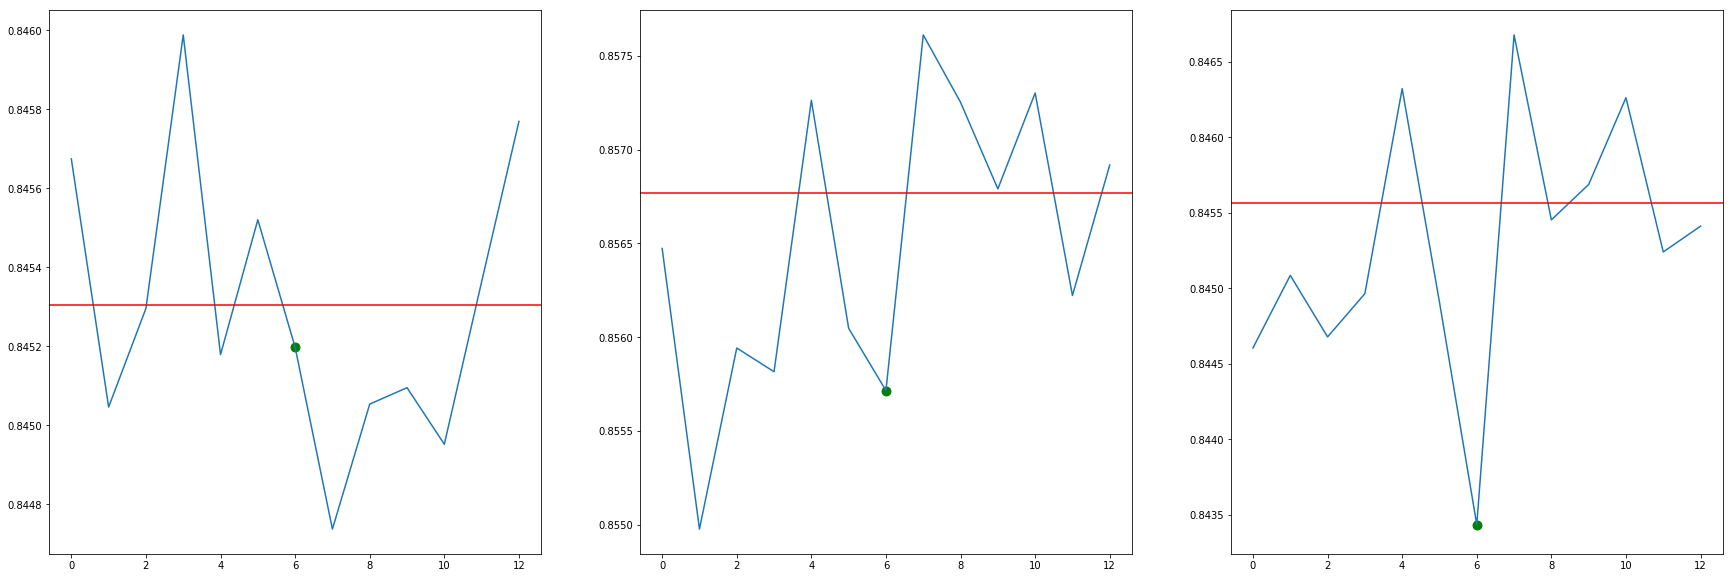

In [30]:
f,axes = plt.subplots(1,3,figsize=(30,10))
for _i in range(3):
    axes[_i].plot(np.asarray(all_dice)[:,_i+1])
    axes[_i].axhline(y=out_dice[_i+1], color='r', linestyle='-')
    axes[_i].scatter([6,],[all_dice[6][_i+1],],s=[80,],c=['green',])

In [17]:
class MorphologyOps(object):
    """
    Class that performs the morphological operations needed to get notably
    connected component. To be used in the evaluation
    """

    def __init__(self, binary_img, neigh):
        assert len(binary_img.shape) == 3, 'currently supports 3d inputs only'
        self.binary_map = np.asarray(binary_img, dtype=np.int8)
        self.neigh = neigh

    def border_map(self):
        """
        Creates the border for a 3D image
        :return:
        """
        west = ndimage.shift(self.binary_map, [-1, 0, 0], order=0)
        east = ndimage.shift(self.binary_map, [1, 0, 0], order=0)
        north = ndimage.shift(self.binary_map, [0, 1, 0], order=0)
        south = ndimage.shift(self.binary_map, [0, -1, 0], order=0)
        top = ndimage.shift(self.binary_map, [0, 0, 1], order=0)
        bottom = ndimage.shift(self.binary_map, [0, 0, -1], order=0)
        cumulative = west + east + north + south + top + bottom
        border = ((cumulative < 6) * self.binary_map) == 1
        return border


    def foreground_component(self):
        return ndimage.label(self.binary_map)

In [22]:
def borders(seg, ref, neigh=8):
    """
    This function determines the points that lie on the border of the
    inferred and reference segmentations
    :param seg: numpy array with binary mask from inferred segmentation
    :param ref: numpy array with binary mask from reference segmentation
    :param neigh: connectivity 4 or 8
    :return: numpy arrays of reference and inferred segmentation borders
    """
    border_ref = MorphologyOps(ref, neigh).border_map()
    border_seg = MorphologyOps(seg, neigh).border_map()
    return border_ref, border_seg

In [23]:
def border_distance(seg, ref, neigh=8):
    """
    This functions determines the distance at each seg border point to the
    nearest ref border point and vice versa
    :param seg: numpy array with binary mask from inferred segmentation
    :param ref: numpy array with binary mask from reference segmentation
    :param neigh: connectivity 4 or 8
    :return: numpy arrays for distance_from_ref_border, distance_from
    seg_border
    """
    border_ref, border_seg = borders(seg, ref, neigh)
    distance_ref = ndimage.distance_transform_edt(1 - border_ref)
    distance_seg = ndimage.distance_transform_edt(1 - border_seg)
    distance_border_seg = border_ref * distance_seg
    distance_border_ref = border_seg * distance_ref
    return distance_border_ref, distance_border_seg

In [24]:
def hausdorff_distance(seg, ref):
    ref_border_dist, seg_border_dist = border_distance(seg, ref, 8)
    return np.max([np.max(ref_border_dist), np.max(seg_border_dist)])

In [25]:
def hausdorff95_distance(seg, ref):
    ref_border_dist, seg_border_dist = border_distance(seg, ref, 8)
    border_ref, border_seg = borders(seg, ref, 8)
    seg_values = ref_border_dist[border_seg > 0]
    ref_values = seg_border_dist[border_ref > 0]
    if seg_values.size == 0 or ref_values.size == 0:
        return np.nan
    return np.max([np.percentile(seg_values, 95),
                   np.percentile(ref_values, 95)])

In [29]:
def average_distance(seg, ref):
    ref_border_dist, seg_border_dist = border_distance(seg, ref, 8)
    border_ref, border_seg = borders(seg, ref, 8)
    return (np.sum(ref_border_dist) + np.sum(
        seg_border_dist)) / (np.sum(border_ref + border_seg))

In [70]:
def metric_all_labels(seg,ref,metric,labels=[0,1,2,3]):
    ret = []
    for l in labels:
        _s = seg==l
        _r = ref==l
        ret += [metric(_s,_r),]
    ret = np.asarray(ret,dtype=float)
    return ret

In [41]:
metric_all_labels(output_image,true_im,hausdorff_distance)

array([37.33630941, 11.        ,  8.30662386,  9.        ])

In [42]:
metric_all_labels(output_image,true_im,hausdorff95_distance)

array([1.        , 2.23606798, 1.41421356, 1.41421356])

In [43]:
metric_all_labels(output_image,true_im,average_distance)

array([0.5026898 , 0.70157565, 0.6214392 , 0.53821379])

In [30]:
average_distance(output_image,true_im)

10.316307675589863

In [31]:
hausdorff95_distance(output_image,true_im)

36.0236020089081

In [32]:
def Dice(pred,true,labels=[0,1,2,3]):
    l = len(labels)
    ret = np.zeros(l)
    for i in range(l):
        lab = labels[i]
        p = pred==lab
        t = true==lab
        ret[i] = 2*float(np.logical_and(p,t).sum())/(p.sum()+t.sum())
    return ret

In [85]:
def Jaccard(pred,true,labels=[0,1,2,3]):
    l = len(labels)
    ret = np.zeros(l)
    for i in range(l):
        lab = labels[i]
        p = pred==lab
        t = true==lab
        ret[i] = float(np.logical_and(p,t).sum())/float(np.logical_or(p,t).sum())
    return ret

In [86]:
Jaccard(output_image,true_im)

array([0.98935009, 0.73168278, 0.7521117 , 0.73268889])

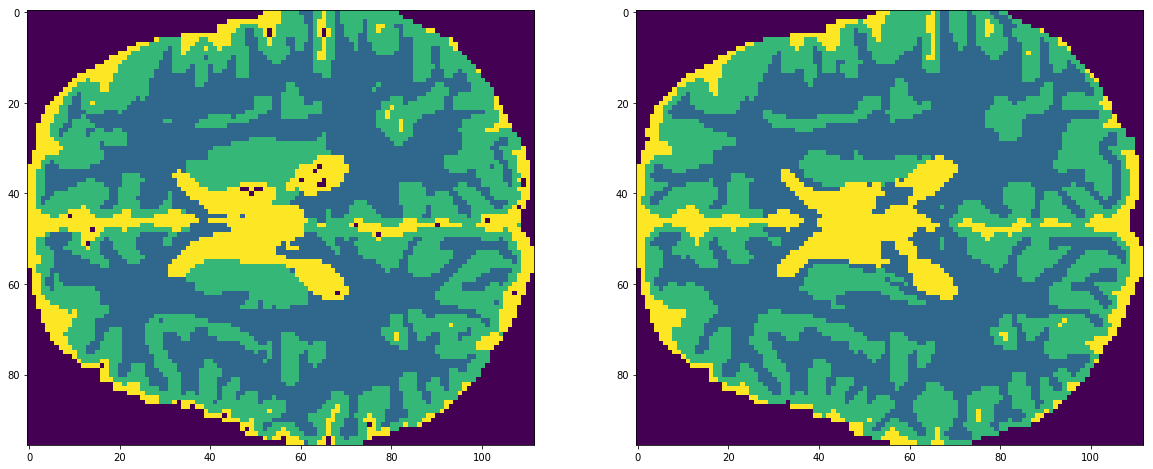

In [97]:
f,axes = plt.subplots(1,2,figsize=(20,20))
axes[0].imshow(output_image[:,:,60])
axes[1].imshow(true_im[:,:,60])


In [88]:
def clean_one_image(arr_original,arr_true):
    arr = deepcopy(arr_original)
    original_dice = Dice(arr,arr_true)
    
    for _l in [0,1,2,3]:
        carr = deepcopy(arr)
        carr[carr!=_l]=0
        labeled, ncomponents = CClabel(carr)
        ls,cs = np.unique(labeled,return_counts=True)
        ls = ls[np.argsort(cs)[:-3]]
        
        for _i in ls:
            arr[labeled==_i]=0
    
    new_dice = Dice(arr,arr_true)
    
    return arr,original_dice,new_dice

In [115]:
s = output_image==3
r = true_im==3

In [116]:
labeled, ncomponents = CClabel(s)

In [117]:
ls,cs = np.unique(labeled,return_counts=True)

In [118]:
cs

array([920596, 109181,      2,      1,      1,      2,      1,      1,
            1,      4,      1,      9,      1,      2,     17,      1,
            1,      1,      1,      2,      1,      1,      3,      1,
           36,      1,     77,      8,     10,      2,      2,      1,
            2,      1,      1,      2,      5,      1,      2,      1,
            1,      5,      1,      1,      1,      3,      1,      2,
            2,      1,      1,      1,     10,     28,      2,      3,
            5,      2,      1,      1,      4,     24,      3,      1,
            4,      1,      1,      1,      6,      3,      1,      1,
            2,      4,      1,     11,      3,      1,      1,      1,
            9,      1,      1,     14,      1,      4,      2,      1,
           12,      2,      1,      1,      1,      1,      1,      2,
           22,     19,      7,      9,     10,      1,      1,      6,
            1,      1,      1,      3,      1,      2,     11,     21,
      

In [114]:
np.argsort(cs)

array([234, 245, 243, 414, 241, 240, 239, 238, 236, 416, 468, 233, 231,
       230, 229, 228, 227, 225, 246, 247, 413, 249, 270, 269, 408, 267,
       409, 265, 264, 263, 224, 262, 260, 410, 411, 256, 255, 252, 412,
       250, 261, 272, 223, 220, 192, 191, 428, 189, 188, 429, 372, 185,
       182, 181, 180, 179, 178, 432, 176, 174, 434, 193, 196, 426, 198,
       219, 218, 216, 215, 214, 212, 419, 420, 221, 421, 423, 206, 205,
       204, 203, 202, 425, 199, 422, 172, 275, 277, 343, 342, 382, 340,
       339, 338, 336, 335, 334, 385, 332, 331, 330, 329, 328, 386, 323,
       344, 345, 346, 347, 371, 374, 375, 367, 366, 365, 364, 363, 322,
       376, 358, 378, 356, 355, 353, 380, 381, 349, 359, 407, 321, 319,
       399, 293, 292, 291, 290, 400, 288, 287, 402, 285, 403, 404, 405,
       281, 280, 406, 278, 397, 396, 298, 299, 318, 389, 390, 315, 314,
       313, 391, 311, 387, 392, 308, 307, 393, 394, 304, 395, 301, 300,
       309, 171, 373, 169,  70,  69,  67, 455,  65,  64,  63,  6

In [105]:
ls = ls[np.argsort(cs)[:-3]]

In [106]:
ls

array([ 64,  59,  58,  99, 100,  55,  54, 101, 102,  51,  50,  49,  48,
        47,  46, 103, 104,  43,  60,  84,  97, 128,  83,  82,  87,  80,
        78,  89,  90,  75,  74,  91,  72,  71,  94,  68,  67,  95,  65,
        62, 105,  42, 107, 106,  18,  17,  16,  14,  13,  12,  19,  11,
         9, 122,   7,   6,   5,   4, 124,  10,  20,  85,  22,  38, 108,
       109,  34,  33, 111, 119, 113, 112,  28,  27,  26, 114, 117,  29,
        93, 121, 110,  88, 115, 125, 127,  96, 129,  81,   2,   3,   8,
        21,  23,  24,  30,  32,  36,  44,  52,  37,  79,  70,  69,  66,
        77,  63,  73,  61,  39, 120,  41,  45,  31,  98,  53, 126,  25,
       123,  56,  92, 116,  15,  57, 118,  76,  86,  35], dtype=int32)